In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import math
import random

from torchsummary import summary
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import LambdaLR
from torch import nn, optim, tensor, Tensor
from sklearn.preprocessing import RobustScaler, StandardScaler

In [3]:
random.seed(52)
torch.manual_seed(52)
np.random.seed(52)

In [4]:
class CandlesDataset(Dataset):
    def __init__(self, root_dir: str, years: list, window_size: int, max_samples: int, device):
        self.device = device
        self.window_size = window_size
        self.tables_list = self.__get_correct_tables(root_dir, years)
        self.samples = self.__generate_samples(self.tables_list, max_samples)
        self.scaled_samples = self.__scale_samples()

    def __get_correct_tables(self, root_dir, years):
        """
        get paths of .csv with len > window_size 
        """
        tables_list = []
        for root, dirs, files in os.walk(root_dir):
            if dirs:
                tables_dirs = dirs
                break
        for table_dir in tables_dirs:
            if int(table_dir[-4:]) in years:
                full_dir = os.path.join(root_dir, table_dir)
                for root, dirs, files in os.walk(full_dir):
                    for file in files:
                        if file.lower().endswith('.csv'):
                            full_path = os.path.join(full_dir, file)
                            with open(full_path) as f:
                                if sum(1 for line in f) > self.window_size:
                                    tables_list.append(full_path)
        random.shuffle(tables_list)
        return tables_list

    def __generate_samples(self, tables_list, max_samples):
        samples = torch.empty((0, self.window_size + 1, 8)) #(n_blocks, window_size, n_features)
        for table in tqdm(tables_list, desc="tables done"):
            df = pd.read_csv(
                table,
                sep =";",
                names=["figi", "utc", "open", "close", "high", "low", "volume"],
                index_col=False
                )
            df['utc'] = pd.to_datetime(df['utc'], utc=True)

            #fill missing candles
            df = df.set_index('utc').resample('min').asfreq()
            df['volume'] = df['volume'].fillna(0)
            for col in ['figi', 'open', 'high', 'low', 'close']:
                df[col] = df[col].ffill()

            #add time data
            df['hour'] = df.index.hour
            df['day_of_week'] = df.index.day_of_week
            df['minute'] = df.index.minute
            df.drop(labels=['figi'], axis=1, inplace=True)

            df = df[(df['day_of_week'] < 5)] #drop not tradeble days

            data = df.values
            if data.shape[0] == 0:
                continue
            windows = np.lib.stride_tricks.sliding_window_view(
                data, (self.window_size + 1, data.shape[1])
            )  #(n_blocks, window_size, n_features)
            tensor = torch.tensor(windows, dtype=torch.float32).squeeze(dim=1)
            samples = torch.vstack([samples, tensor])
            if samples.shape[0] > max_samples:
                break
        return samples

    def __scale_samples(self):
        stds = self.samples[:, :self.window_size-1, :-3].std(dim=1)
        valid_mask = (stds > 1e-7).all(dim=1)
        self.samples = self.samples[valid_mask]
        mean = self.samples[:, :(self.window_size-1), :-3].mean(dim=1, keepdim=True)
        std = self.samples[:, :(self.window_size-1), :-3].std(dim=1, keepdim=True)
        epsilon = 1e-7
        normalized_data = (self.samples[:, :, :-3] - mean) / (std + epsilon)
        normalized_data = torch.cat([normalized_data, self.samples[:, :, -3:]], dim=-1)
        normalized_data[..., -3] = normalized_data[..., -3] / 23
        normalized_data[..., -2] = normalized_data[..., -2] / 6 
        normalized_data[..., -1] = normalized_data[..., -1] / 59
        self.std = std
        self.mean = mean
        return normalized_data


    def __len__(self):
        return len(self.scaled_samples)

    def __getitem__(self, idx):
        sample = self.scaled_samples[idx]
        return sample[:-1, :], sample[-1:, :5].squeeze(dim=0), self.std[idx], self.mean[idx]#feature, target, std, mean

In [ ]:
heads = 4
encoder_layers = 3
d_model = 128
batch_size = 512
window_size = 240
num_workers = 4
root_dir = 'market_data/unzip_data'
model_dir = 'checkpoints/'
max_samples_train = 1000000
max_samples_val = 200000
max_epoch = 10
years_train = [2023]
years_val = [2024]
model_path = os.path.join(model_dir, 'best.tar')
is_preload = False

In [6]:
train_dataset = CandlesDataset(
    root_dir=root_dir, 
    years=years_train, 
    window_size=window_size,
    max_samples=max_samples_train, 
    device=device
    )

val_dataset = CandlesDataset(
    root_dir=root_dir, 
    years=years_val, 
    window_size=window_size,
    max_samples=max_samples_val, 
    device=device
    )

tables done:  28%|██▊       | 407/1448 [01:59<05:06,  3.40it/s]


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

In [8]:
class TimeEncoder(nn.Module):
    def __init__(self, candles_features: int, time_features: int, d_model: int):
        super().__init__()
        self.input_proj = nn.Linear(candles_features, d_model)
        self.time2vec = nn.Sequential(
            nn.Linear(time_features, 32),
            nn.GELU(),
            nn.Linear(32, d_model)
        )
        self.learnable_pe = nn.Parameter(torch.randn(1, 5000, d_model))
        
    def forward(self, x):
        x, time_features = x[:, :, :5], x[:, :, 5:]
        t_emb = self.time2vec(time_features)
        x = self.input_proj(x)
        x = x + self.learnable_pe[:, :x.size(1), :] + t_emb
        return x

In [9]:
class Transformer(nn.Module):
    def __init__(self, d_model: int, nhead: int, encoder_layers: int):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, batch_first=True),
            num_layers=encoder_layers
        )

    def forward(self, x):
        x = self.encoder(x).mean(dim=1)
        return x

In [10]:
class CandleTransformer(nn.Module):
    def __init__(self, heads: int, encoder_layers: int, d_model: int):
        super().__init__()
        self.time_enc = TimeEncoder(candles_features=5, time_features=3, d_model=d_model)
        self.transformer = Transformer(d_model=d_model, nhead=heads, encoder_layers=encoder_layers)
        self.out = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 5)
            )

    def forward(self, x):
        """
        # prices: [B, 180, 5] (OHLCV)
        # indicators: [B, 180, 4]
        # time_feats: [B, 180, 3]
        """
        x = self.time_enc(x)
        trans_out = self.transformer(x)
        out = self.out(trans_out)
        return out

In [11]:
def direction_accuracy(pred, true):
    direction_pred = torch.sign(pred[:, 3] - pred[:, 0]) # open - close
    direction_true = torch.sign(true[:, 3] - true[:, 0])
    return (direction_pred == direction_true).float().mean()

Text(0, 0.5, 'Learning Rate')

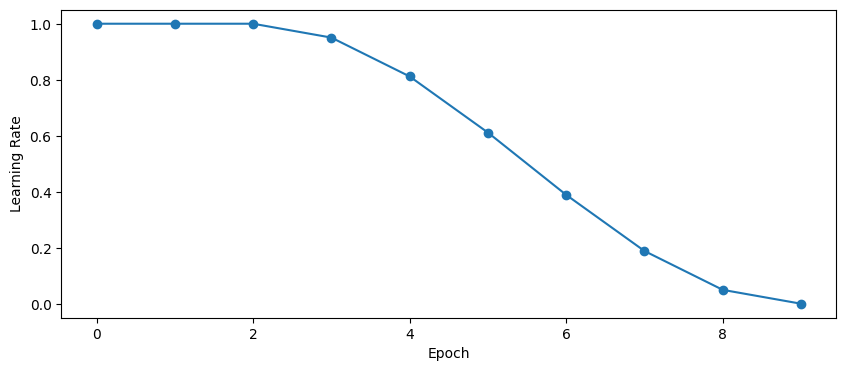

In [12]:
LR_START = 1e-4
LR_MAX = 1e-4
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 2

def lr_lambda(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = max_epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr / LR_START
# cosine sheduler

rng = [i for i in range(max_epoch)]
lr_y = [lr_lambda(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [13]:
def weighted_mse_loss(
        pred, 
        target, 
        weights=torch.tensor([0.8, 0.6, 0.6, 1.0, 0.2]).to(device)
        ):
    return (weights * (pred - target) ** 2).mean()

In [14]:
model = CandleTransformer(
    heads=heads,
    encoder_layers=encoder_layers, 
    d_model=d_model,
    ).to(device=device)

criterion = weighted_mse_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [15]:
train_losses = []
val_losses = []
dir_accuracies = []
current_epoch = 0

if is_preload:
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    current_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    dir_accuracies = checkpoint['dir_accuracies']
    print('Preload model')

for epoch in range(current_epoch, max_epoch):
    model.train()
    running_loss = 0
    
    for features, targets, _, _  in tqdm(train_loader, desc=f"Train Epoch {epoch + 1}"):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)
    train_loss = running_loss / len(train_dataset)

    model.eval()
    val_running_loss = 0
    all_targets = []
    all_preds = []
    for features, targets, _ , _ in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        val_running_loss += criterion(outputs, targets).item() * features.size(0)
        all_preds.append(outputs.detach().cpu())
        all_targets.append(targets.detach().cpu())
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = val_running_loss / len(val_dataset)

    dir_accuracy = direction_accuracy(all_preds, all_targets)
    dir_accuracies.append(dir_accuracy)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dir_accuracies': dir_accuracies
        }, os.path.join(model_dir, f'baseline_{epoch}.tar'))
    if len(val_losses) == 0 or val_loss < min(val_losses):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'dir_accuracies': dir_accuracies
            }, os.path.join(model_dir, f'best.tar'))
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    print(f'LR: {current_lr:.4e}')
    print(f"Epoch {epoch+1}/{max_epoch}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}\n")
    print(f"Val direction Accuracy: {dir_accuracy:.4f}\n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    dir_accuracies.append(dir_accuracy)
    scheduler.step()

Validation Epoch 1: 100%|██████████| 392/392 [00:47<00:00,  8.28it/s]


LR: 1.0000e-04
Epoch 1/10
Train Loss: 0.1886
Val Loss: 0.1150

Val direction Accuracy: 0.6384



Validation Epoch 2: 100%|██████████| 392/392 [00:47<00:00,  8.25it/s]


LR: 1.0000e-04
Epoch 2/10
Train Loss: 0.1100
Val Loss: 0.1097

Val direction Accuracy: 0.6280



Validation Epoch 3: 100%|██████████| 392/392 [00:47<00:00,  8.26it/s]


LR: 8.1193e-05
Epoch 3/10
Train Loss: 0.1068
Val Loss: 0.1066

Val direction Accuracy: 0.6686



Validation Epoch 4: 100%|██████████| 392/392 [00:47<00:00,  8.27it/s]


LR: 3.8935e-05
Epoch 4/10
Train Loss: 0.1048
Val Loss: 0.1048

Val direction Accuracy: 0.6559



Validation Epoch 5: 100%|██████████| 392/392 [00:47<00:00,  8.26it/s]


LR: 5.0466e-06
Epoch 5/10
Train Loss: 0.1039
Val Loss: 0.1045

Val direction Accuracy: 0.6618



Validation Epoch 6: 100%|██████████| 392/392 [00:47<00:00,  8.28it/s]


LR: 5.0466e-06
Epoch 6/10
Train Loss: 0.1038
Val Loss: 0.1042

Val direction Accuracy: 0.6475



Validation Epoch 7: 100%|██████████| 392/392 [00:47<00:00,  8.25it/s]


LR: 3.8935e-05
Epoch 7/10
Train Loss: 0.1043
Val Loss: 0.1041

Val direction Accuracy: 0.6088



Validation Epoch 8: 100%|██████████| 392/392 [00:47<00:00,  8.31it/s]


LR: 8.1193e-05
Epoch 8/10
Train Loss: 0.1044
Val Loss: 0.1057

Val direction Accuracy: 0.6456



Validation Epoch 9: 100%|██████████| 392/392 [00:47<00:00,  8.23it/s]


LR: 1.0000e-04
Epoch 9/10
Train Loss: 0.1039
Val Loss: 0.1025

Val direction Accuracy: 0.6601



Validation Epoch 10: 100%|██████████| 392/392 [00:47<00:00,  8.22it/s]

LR: 8.1193e-05
Epoch 10/10
Train Loss: 0.1028
Val Loss: 0.1017

Val direction Accuracy: 0.6310



In [16]:
print('Min validation loss: ', min(val_losses))

Min validation loss:  0.1017062010434878


record: 1.017

In [17]:
max_counter = 10
dataloader = DataLoader(val_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
counter = 0
for features, targets, std, mean in dataloader:
    features, targets, std, mean = features.to(device), targets.to(device), std.to(device), mean.to(device)
    optimizer.zero_grad()
    outputs = model(features).detach()
    print(f"Target: ", (targets*std+mean).cpu())
    print(f"Output: ", (outputs*std+mean).cpu())
    print()
    counter += 1
    if counter == max_counter:
        break

Target:  tensor([[[ 160.3300,  160.3200,  160.3900,  160.1000, 7477.0000]]])
Output:  tensor([[[ 160.3436,  160.3363,  160.3598,  160.3181, 1292.1404]]])

Target:  tensor([[[  130.1900,   130.2400,   130.2600,   130.1800, 11584.0000]]])
Output:  tensor([[[  130.2023,   130.2002,   130.2547,   130.1211, 14760.0625]]])

Target:  tensor([[[304.9900, 304.9900, 305.0000, 304.9800, 338.0000]]])
Output:  tensor([[[ 304.9821,  304.9701,  305.0110,  304.9469, 2735.1572]]])

Target:  tensor([[[ 135.8300,  135.7000,  135.8700,  135.7000, 5804.0000]]])
Output:  tensor([[[ 135.8114,  135.8080,  135.8662,  135.7619, 5226.7119]]])

Target:  tensor([[[2.5000e-02, 2.5000e-02, 2.5000e-02, 2.4995e-02, 3.0756e+04]]])
Output:  tensor([[[2.5001e-02, 2.5004e-02, 2.5015e-02, 2.4985e-02, 3.5561e+04]]])

Target:  tensor([[[  161.4300,   161.2400,   161.4300,   161.1500, 33711.0000]]])
Output:  tensor([[[  161.3668,   161.3514,   161.4552,   161.2554, 13427.3984]]])

Target:  tensor([[[  90.5700,   90.5400,   90